In [1]:
import tensorflow as tf
from tensorflow import keras
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import RMSprop, SGD, Adam
from tensorflow.keras.regularizers import L1L2, L1, L2 
from keras.callbacks import ModelCheckpoint, EarlyStopping
from tensorflow.keras.layers import Dense, Convolution2D, MaxPooling2D, Flatten , Activation, Lambda, Convolution1D
from tensorflow.keras.utils import to_categorical
import os
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Dropout
from keras.layers import LSTM
from keras.callbacks import ModelCheckpoint
from sklearn.model_selection import train_test_split
from keras import utils 
import pandas as pd

In [3]:
X = pd.read_csv("jena_climate_2009_2016.csv").drop(columns=["Date Time"]).astype('float32') # todos los datos 
Y = pd.read_csv("jena_climate_2009_2016.csv").pop("T (degC)") # temp
X.shape

(420551, 14)

In [71]:
X

,p (mbar),T (degC),Tpot (K),Tdew (degC),rh (%),VPmax (mbar),VPact (mbar),VPdef (mbar),sh (g/kg),H2OC (mmol/mol),rho (g/m**3),wv (m/s),max. wv (m/s),wd (deg)
0,996.520020,-8.02,265.399994,-8.90,93.300003,3.33,3.11,0.22,1.94,3.12,1307.750000,1.03,1.75,152.300003
1,996.570007,-8.41,265.010010,-9.28,93.400002,3.23,3.02,0.21,1.89,3.03,1309.800049,0.72,1.50,136.100006
2,996.530029,-8.51,264.910004,-9.31,93.900002,3.21,3.01,0.20,1.88,3.02,1310.239990,0.19,0.63,171.600006
3,996.510010,-8.31,265.119995,-9.07,94.199997,3.26,3.07,0.19,1.92,3.08,1309.189941,0.34,0.50,198.000000
4,996.510010,-8.27,265.149994,-9.04,94.099998,3.27,3.08,0.19,1.92,3.09,1309.000000,0.32,0.63,214.300003
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
420546,1000.070007,-4.05,269.100006,-8.13,73.099998,4.52,3.30,1.22,2.06,3.30,1292.979980,0.67,1.52,240.000000
420547,999.929993,-3.35,269.809998,-8.06,69.709999,4.77,3.32,1.44,2.07,3.32,1289.439941,1.14,1.92,234.300003
420548,999.820007,-3.16,270.010010,-8.21,67.910004,4.84,3.28,1.55,2.05,3.28,1288.390015,1.08,2.00,215.199997
420549,999.809998,-4.23,268.940002,-8.53,71.800003,4.46,3.20,1.26,1.99,3.20,1293.560059,1.49,2.16,225.800003


In [4]:
s = X.shape[0]

h = round(s/2) - 1 # half
q = round(s/4) # quarter
print(f"{h}, {q}")

210275, 105138


In [9]:
dt_train = keras.utils.timeseries_dataset_from_array(
    data=Y.iloc[:-10], 
    targets=Y.iloc[10:],
    sequence_length=10,
    start_index=0,
    end_index=h,
    shuffle=True
)
dt_valid = keras.utils.timeseries_dataset_from_array(
    data=Y.iloc[:-10], 
    targets=Y.iloc[10:],
    sequence_length=10,
    start_index=h,
    end_index=h+q,
    shuffle=True
)
dt_test = keras.utils.timeseries_dataset_from_array(
    data=Y.iloc[:-10], 
    targets=Y.iloc[10:],
    sequence_length=10,
    start_index=h+q,
    end_index=h+2*(q-5) - 1,
    shuffle=True
)
train = list(dt_train.unbatch())
# test = list(dt_test.unbatch())
# valid = list(dt_valid.unbatch())

In [10]:
dt_train.cardinality()

<tf.Tensor: shape=(), dtype=int64, numpy=1643>

In [11]:
filepath = "best_model1Shuffle.hdf5"
checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=True, mode='min')
earlystop = EarlyStopping(monitor='val_loss', mode='min', restore_best_weights=True, patience=5, verbose=1)

model = Sequential([
    LSTM(256, input_shape=(len(train[0][0]), 1)),
    Dropout(0.2),
    Dense(1)
])

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 256)               264192    
                                                                 
 dropout (Dropout)           (None, 256)               0         
                                                                 
 dense (Dense)               (None, 1)                 257       
                                                                 
Total params: 264,449
Trainable params: 264,449
Non-trainable params: 0
_________________________________________________________________


In [12]:
model.compile(loss="mean_squared_error", optimizer=Adam(learning_rate=0.001))
history = model.fit(dt_train, epochs=50, validation_data=dt_valid, callbacks=[earlystop, checkpoint])

Epoch 1/50
1641/1643 [============================>.] - ETA: 0s - loss: 1.3816
Epoch 1: val_loss improved from inf to 0.09756, saving model to best_model1Shuffle.hdf5
1643/1643 [==============================] - 48s 28ms/step - loss: 1.3804 - val_loss: 0.0976
Epoch 2/50
1643/1643 [==============================] - ETA: 0s - loss: 0.2511
Epoch 2: val_loss improved from 0.09756 to 0.05116, saving model to best_model1Shuffle.hdf5
1643/1643 [==============================] - 45s 28ms/step - loss: 0.2511 - val_loss: 0.0512
Epoch 3/50
1641/1643 [============================>.] - ETA: 0s - loss: 0.2303
Epoch 3: val_loss improved from 0.05116 to 0.04257, saving model to best_model1Shuffle.hdf5
1643/1643 [==============================] - 45s 27ms/step - loss: 0.2303 - val_loss: 0.0426
Epoch 4/50
1641/1643 [============================>.] - ETA: 0s - loss: 0.2225
Epoch 4: val_loss did not improve from 0.04257
1643/1643 [==============================] - 45s 28ms/step - loss: 0.2225 - val_loss: 

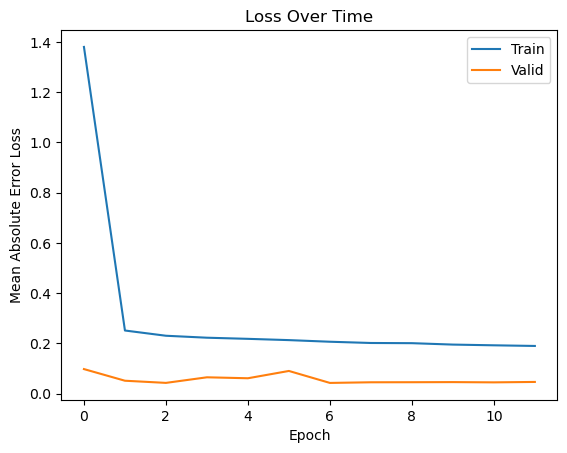

In [13]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])

plt.xlabel('Epoch')
plt.ylabel('Mean Absolute Error Loss')
plt.title('Loss Over Time')
plt.legend(['Train','Valid'])

In [14]:
test = model.predict(dt_test)

822/822 [==============================] - 10s 11ms/step


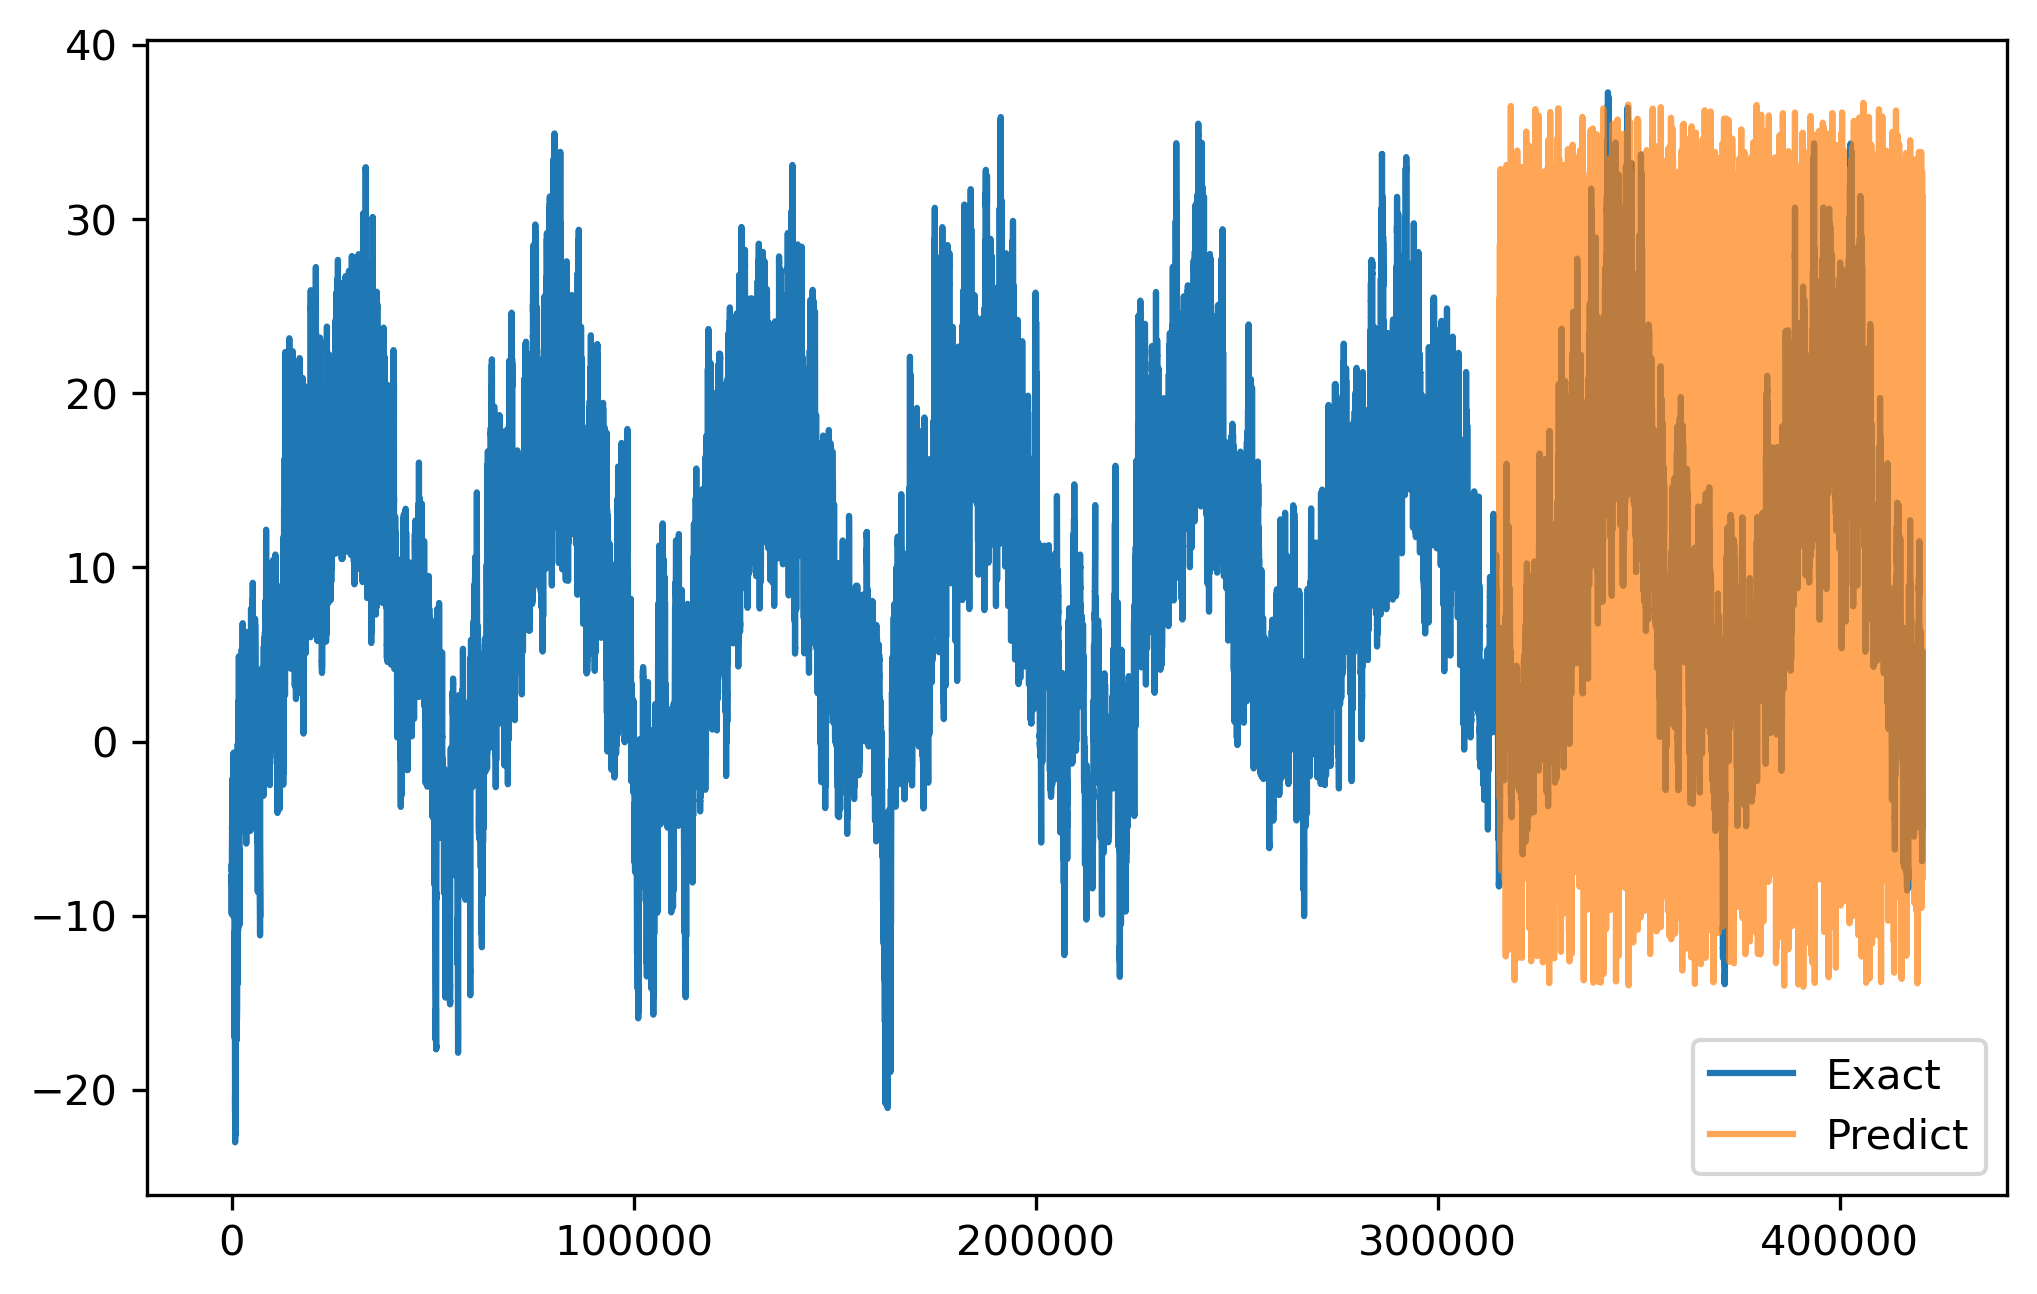

In [16]:
plt.figure(dpi=300, figsize=(8, 5))
plt.plot(range(len(Y)), Y, label="Exact")
plt.plot(range(len(Y))[h+q:h+2*(q-10)], test, label="Predict", alpha=0.7)
plt.legend()